# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [39]:
import os
import sys
import re

import tensorflow as tf
from tensorflow.contrib.layers import flatten
import tensorflow.python.platform
from tensorflow.python.platform import gfile

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from collections import Counter

# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [40]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [41]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [42]:
### Data exploration visualization goes here.

In [43]:
z = np.array(train['labels'])
Counter(z)

Counter({0: 210,
         1: 2220,
         2: 2250,
         3: 1410,
         4: 1980,
         5: 1860,
         6: 420,
         7: 1440,
         8: 1410,
         9: 1470,
         10: 2010,
         11: 1320,
         12: 2100,
         13: 2160,
         14: 780,
         15: 630,
         16: 420,
         17: 1110,
         18: 1200,
         19: 210,
         20: 360,
         21: 330,
         22: 390,
         23: 510,
         24: 270,
         25: 1500,
         26: 600,
         27: 240,
         28: 540,
         29: 270,
         30: 450,
         31: 780,
         32: 240,
         33: 689,
         34: 420,
         35: 1200,
         36: 390,
         37: 210,
         38: 2070,
         39: 300,
         40: 360,
         41: 240,
         42: 240})

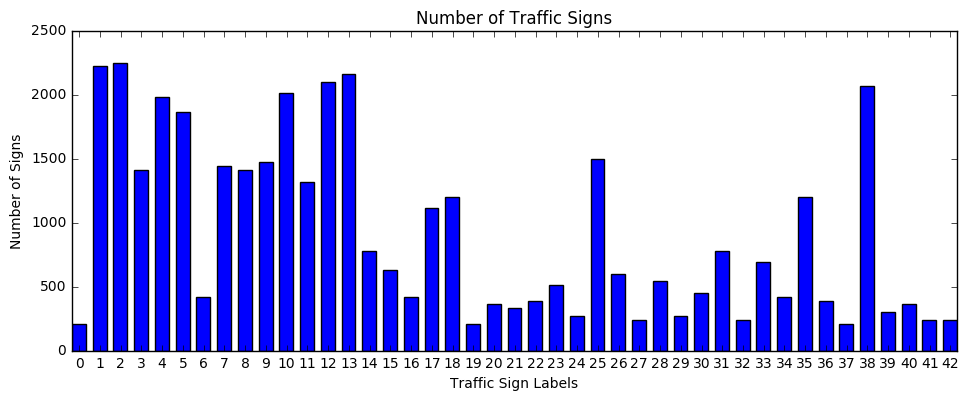

In [44]:
labels, values = zip(*Counter(z).items())

indexes = np.arange(len(labels))
width = 1


plt.xticks(indexes + 0.35, labels)
plt.ylabel('Number of Signs')
plt.xlabel('Traffic Sign Labels')

width = 1/1.5
plt.bar(indexes, values, width )
plt.subplots_adjust(bottom=0.1, right=1.6, top=0.9)

plt.title('Number of Traffic Signs')
plt.show()

In [45]:
def plot_random_preprocess(n_row,n_col,X,y):

    plt.figure(figsize = (11,8))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

    for i in range(n_row*n_col):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[i])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        ind_plot = np.random.randint(1,len(y))
        plt.imshow(X[ind_plot])
        plt.text(2,4,str(y[ind_plot]),
             color='k',backgroundcolor='c')
        plt.axis('off')
    plt.show()

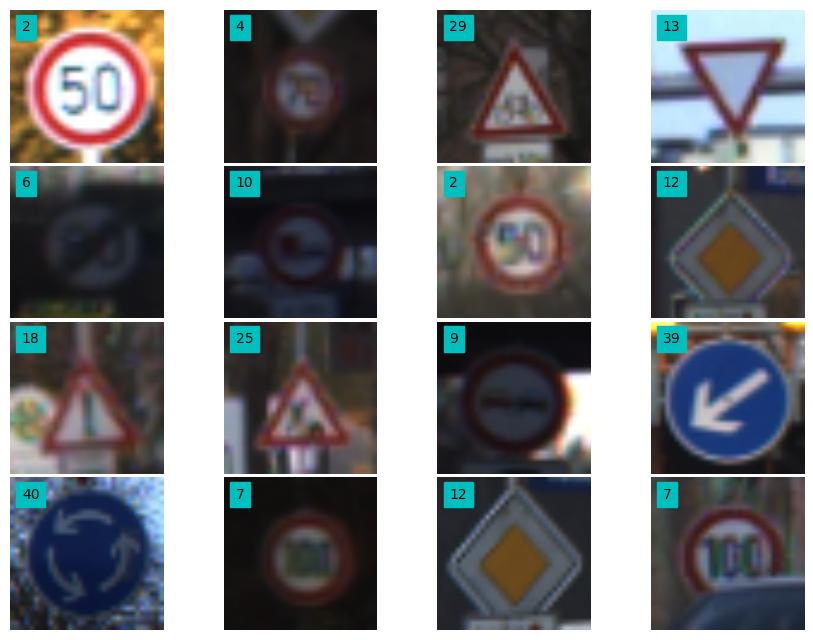

In [46]:
plot_random_preprocess(4, 4, X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [47]:
def normalize(image):
    img = image / 255. * 0.8 + 0.1
    return img

In [48]:
### Preprocess the data here.
# 1.> Normalize 
X_train = np.array([normalize(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
X_test = np.array([normalize(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

# Split the training data into training and validation data by cross validation
# X_train = X_train / 255. * 0.8 + 0.1

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.2, random_state=0) 

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [49]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 100 # 15,30
BATCH_SIZE = 25 #64, 128

In [50]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [51]:
# One hot Encoding 

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [52]:
# Pipe Line 

rate = 0.001 

logits = LeNet(x)
prediction = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [53]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [54]:
### Train your model here.

#save_file = os.getcwd() + file # os.getcwd() is for current working directory
file = 'C:/self-drive/self-drive-car/CarND-Traffic-Sign-Classifier-Project-master/'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    try:
        saver 
    except NameError:
        saver = tf.train.Saver()
    # saver.save(sess, save_file)
    saver.save(sess, file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.469

EPOCH 2 ...
Validation Accuracy = 0.703

EPOCH 3 ...
Validation Accuracy = 0.792

EPOCH 4 ...
Validation Accuracy = 0.869

EPOCH 5 ...
Validation Accuracy = 0.858

EPOCH 6 ...
Validation Accuracy = 0.908

EPOCH 7 ...
Validation Accuracy = 0.882

EPOCH 8 ...
Validation Accuracy = 0.930

EPOCH 9 ...
Validation Accuracy = 0.934

EPOCH 10 ...
Validation Accuracy = 0.924

EPOCH 11 ...
Validation Accuracy = 0.924

EPOCH 12 ...
Validation Accuracy = 0.937

EPOCH 13 ...
Validation Accuracy = 0.934

EPOCH 14 ...
Validation Accuracy = 0.935

EPOCH 15 ...
Validation Accuracy = 0.946

EPOCH 16 ...
Validation Accuracy = 0.938

EPOCH 17 ...
Validation Accuracy = 0.957

EPOCH 18 ...
Validation Accuracy = 0.942

EPOCH 19 ...
Validation Accuracy = 0.958

EPOCH 20 ...
Validation Accuracy = 0.946

EPOCH 21 ...
Validation Accuracy = 0.945

EPOCH 22 ...
Validation Accuracy = 0.957

EPOCH 23 ...
Validation Accuracy = 0.955

EPOCH 24 ...
Validation Accura

In [33]:
# Testing the model

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('C:/self-drive-car/CarND-Traffic-Sign-Classifier/traffic_sign.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.865


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Peprocessed the data by using test_train_split to split the data into training and validation set with 20% training data.

Because splitting a dataset into some ratio of training and testing subsets avoid overfitting. Because it will behave well on the unseen data also. if we dont split the data into training and testing and use the same data for both testing and training also then it will score well on the seen data but fail to predict on the unseen data.

In [34]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
I have used test_train_split to generate training and validation data set into 20:80.
Than used training data to train the model and then used the validation set to validate the model. 
After runnning the model several times we will finally run our model with testing data.

In [21]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))

    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

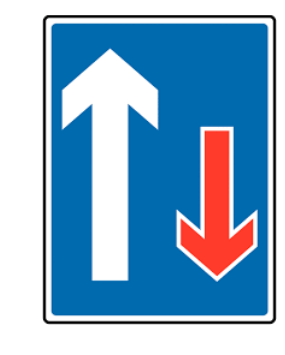

In [22]:
image = mpimg.imread('direct.png')
plt.imshow(image);
plt.axis('off');

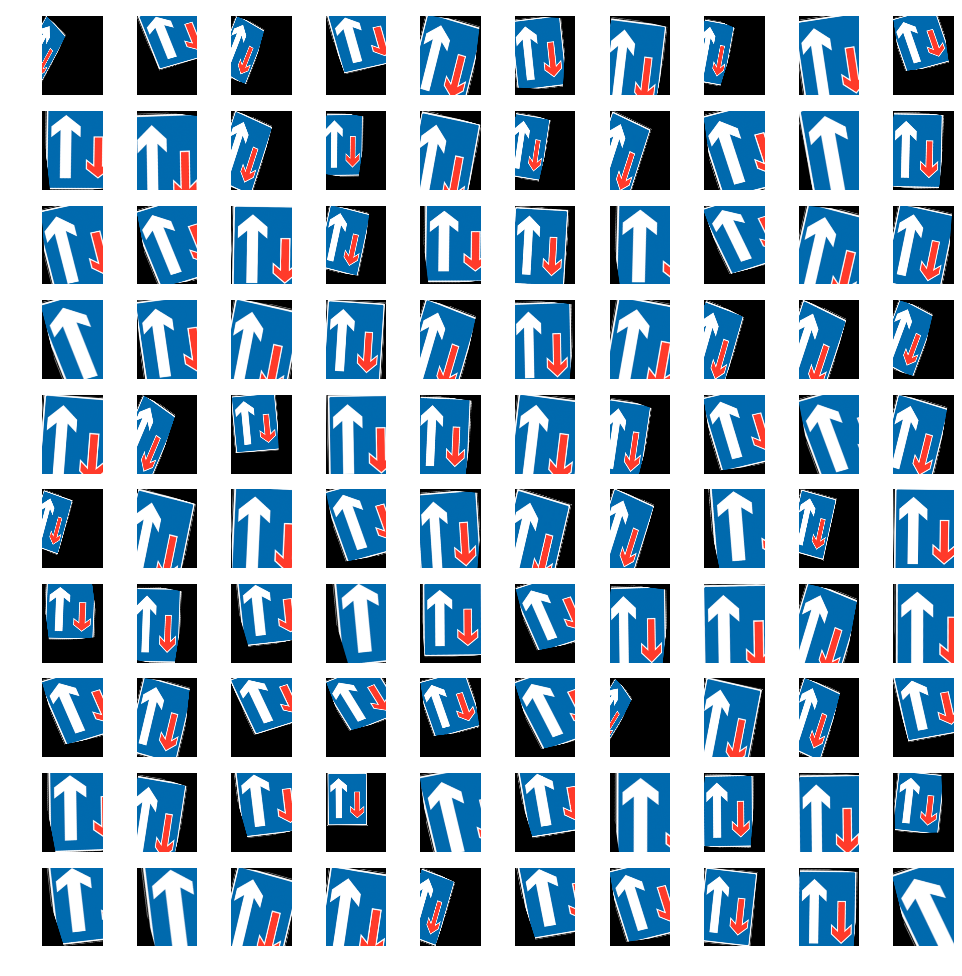

In [23]:
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,20,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Here in final Architecture we have 5 layers.
1st and 2nd layer is a convolution layer after every convolution there is a pooling layer and the last 3 layers are fully connected layer.

1st layer has i/p - 32x32x3 with kernel -> 5x5x3x6 and stride ->  [1, 1, 1, 1]. After applying tensorflow convolution it gives o/p of 28x28x6.
Than it passes into pooling layer as i/p which has the ksize -> [1, 2, 2, 1] and strides -> [1, 2, 2, 1] produces o/p 14x14x6 that is i/p for 2nd layer.

2nd layer is also a convolution layer with kernel -> 5x5x6x16 and stride ->  [1, 1, 1, 1] produces o /p -> 10x10x16 which we again pass to pooling layer as i/p with ksize -> [1, 2, 2, 1] and strides -> [1, 2, 2, 1] produces o/p -> 5x5x16.
After that we have fully connected layer so need to flatten the i/p.
So after flattening the i/p size is now 400.

After flatteing that o/p 400 is i/p for 3rd (fully connected) layer which gives o/p 120.

That is pass as i/p to 4rth (fully connected) layer which gives o/p 84.

which passes as i/p to 5th( final fully connected layer) which produces the o/p 43 means these are the no of classes it produce to classify the i/p images.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I have used these parameter and hyperparamere to tune the model.

Parameter 

optimizer - AdamOptimizer

batch_size - 30

epochs - 64

learning_rate - 0.001

hyperparameters


mu - 0

sigma - 0.1


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I have taken an already implemented architecture LeNet THan have tried trial and error on different hyperparameter like learning_rate, batch_size and epochs for the current problem.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [24]:
data_pd = pd.read_csv('signnames.csv')

In [25]:
data_i = [[i,sum(y_train == i)] for i in range(len(np.unique(y_train)))]
data_i_sorted = sorted(data_i, key=lambda x: x[1])

In [26]:
data_pd['Occurance'] = pd.Series(np.asarray(data_i_sorted).T[1], index=np.asarray(data_i_sorted).T[0])
data_pd_sorted = data_pd.sort_values(['Occurance'],ascending=[0]).reset_index()
data_pd_sorted = data_pd_sorted.drop('index', 1)

In [27]:
data_pd_sorted.head(10)

,ClassId,SignName,Occurance
0,2,Speed limit (50km/h),445
1,13,Yield,434
2,1,Speed limit (30km/h),418
3,38,Keep right,414
4,12,Priority road,413
5,10,No passing for vehicles over 3.5 metric tons,407
6,4,Speed limit (70km/h),395
7,5,Speed limit (80km/h),373
8,9,No passing,303
9,7,Speed limit (100km/h),291


In [28]:
data_pd_sorted.tail(10)

,ClassId,SignName,Occurance
33,39,Keep left,60
34,42,End of no passing by vehicles over 3.5 metric ...,56
35,41,End of no passing,54
36,19,Dangerous curve to the left,52
37,32,End of all speed and passing limits,48
38,0,Speed limit (20km/h),48
39,29,Bicycles crossing,47
40,27,Pedestrians,47
41,24,Road narrows on the right,45
42,37,Go straight or left,43


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


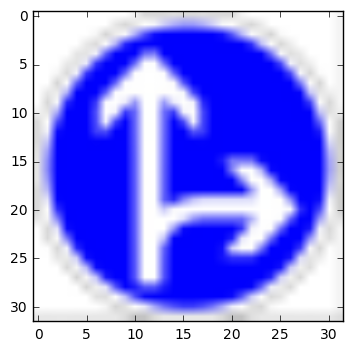

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


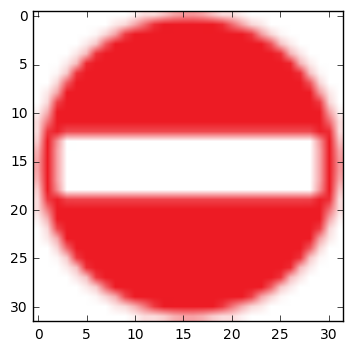

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


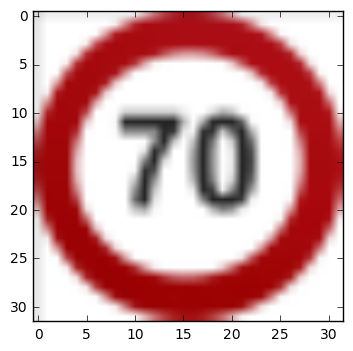

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


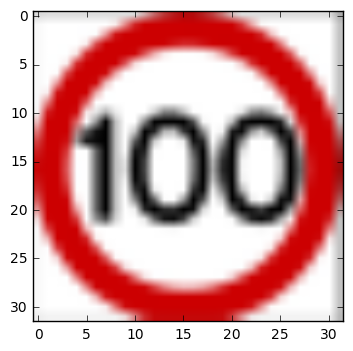

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


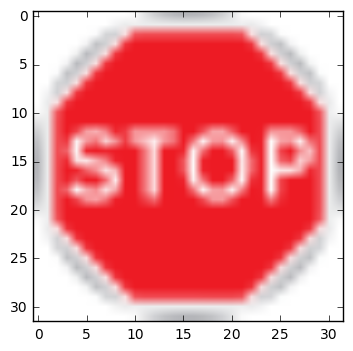

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg

#To read the images from directory 

imgs = ['Go_straight_or_right.jpg', 'No_Entry.jpg', 'Speed_limit_70.jpg', 'Speed_limit_100.jpg', 'Stop.jpg']

new_image = []

for imgname in imgs:
    #reading in an image
    image = mpimg.imread('C:/self-drive/self-drive-car/CarND-Traffic-Sign-Classifier-Project-master/images/' + imgname)
    resized_image = cv2.resize(image, (32, 32), interpolation = cv2.INTER_AREA)
    #resized_image = cv2.resize(image, (32, 32))
    new_image.append(resized_image)
    print('This image is:', type(resized_image), 'with dimesions:', resized_image.shape)
    plt.imshow(resized_image)  
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I have taken 5 images in which it will get the prediction on 2 and three of them got unpredicted.

In [32]:
# Normalize the new image set 
X_train = np.array([normalize(new_image[i]) for i in range(len(new_image))],
                          dtype = np.float32)

In [75]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

init = tf.global_variables_initializer()

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(init)

#new_predictions_no_training = session.run(x, feed_dict={x: new_image})
new_predictions_no_training = session.run(prediction, feed_dict={x: X_train})

In [68]:
print(new_predictions_no_training)

[[ 0.02450896  0.02257193  0.02173477  0.02971551  0.02882279  0.0192722
   0.02032956  0.0206768   0.02465641  0.0268404   0.01910594  0.02310617
   0.02297835  0.0185825   0.02004942  0.02241583  0.02831651  0.02099386
   0.02447545  0.02548659  0.02415681  0.01829666  0.02854002  0.02161836
   0.02093603  0.02780429  0.02558484  0.02908545  0.02250621  0.03112007
   0.02178637  0.01917949  0.02762956  0.01667294  0.02245019  0.02660345
   0.0208138   0.02190356  0.02218586  0.01975466  0.02490431  0.02694322
   0.01488391]
 [ 0.02466733  0.02250786  0.01893618  0.02598073  0.03224818  0.01905521
   0.02182364  0.02272912  0.02618837  0.02335243  0.02280033  0.02111083
   0.01947114  0.01987987  0.02361069  0.02428657  0.02383959  0.02173463
   0.02738406  0.02338253  0.02606026  0.02007265  0.0237761   0.02276582
   0.02268528  0.02481269  0.02316992  0.02227499  0.02320607  0.03178694
   0.02123607  0.02192804  0.02403303  0.01780993  0.02422686  0.02518548
   0.02383401  0.0216087

In [76]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('C:/self-drive-car/CarND-Traffic-Sign-Classifier/traffic_sign.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    new_predictions = sess.run(x, feed_dict={x: X_train})

In [78]:
print(new_predictions)    

[[[[ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   ..., 
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.8654902   0.8654902   0.8654902 ]]

  [[ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   ..., 
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.8654902   0.8654902   0.8654902 ]]

  [[ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   ..., 
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.8654902   0.8654902   0.8654902 ]]

  ..., 
  [[ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   ..., 
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.89999998  0.89999998  0.89999998]
   [ 0.

In [80]:
max_value = np.argmax(new_predictions[0])
print(max_value) 

max_value = np.argmax(new_predictions[1])
print(max_value) 

max_value = np.argmax(new_predictions[2])
print(max_value) 

max_value = np.argmax(new_predictions[3])
print(max_value) 

max_value = np.argmax(new_predictions[4])
print(max_value) 

0
0
99
99
0


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.